## Imports

1. https://mxnet.incubator.apache.org/versions/master/tutorials/python/data_augmentation.html
2. https://stackoverflow.com/questions/48957333/does-mxnet-read-training-data-from-s3-in-a-streaming-fashion
3. https://mxnet.incubator.apache.org/api/python/image/image.html?highlight=imagedetiter#mxnet.image.ImageDetIter
4. https://mxnet.incubator.apache.org/api/python/gluon/data.html#mxnet.gluon.data.vision.datasets.ImageRecordDataset
5. https://mxnet.incubator.apache.org/versions/master/tutorials/gluon/data_augmentation.html
6. http://d2l.ai/chapter_computer-vision/fine-tuning.html
7. https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/
8. https://github.com/d2l-ai/d2l-en/blob/master/d2l/utils.py
9. http://d2l.ai/chapter_computer-vision/fine-tuning.html


* Fail to prepare rec file because some images were corrupted
* prepared .lst file manually
* command executed to convert images to rec


* train on small images and then bigger


In [1]:
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import subprocess
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt

import mxnet as mx
import pandas as pd
import os
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
import csv

#FOLDER = '/Users/francesco/Notebooks/personal/data/movies'
BUCKET = 's3://movies-posters-raw/'

## Data Preprocessing

In [2]:
#df = pd.read_csv(os.path.join(FOLDER, 'movie-genre-from-its-poster', 'MovieGenre.csv'), encoding='latin1')
df = pd.read_csv(BUCKET+'MovieGenre.csv', encoding='latin1')
df = df.drop_duplicates()
df = df.loc[~pd.isnull(df.Genre)]
df.shape

(39370, 6)

In [3]:
df['split_genres'] = df.Genre.str.split('|')
df[['Genre', 'split_genres']].head()

,Genre,split_genres
0,Animation|Adventure|Comedy,"[Animation, Adventure, Comedy]"
1,Action|Adventure|Family,"[Action, Adventure, Family]"
2,Comedy|Romance,"[Comedy, Romance]"
3,Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,Comedy|Family|Romance,"[Comedy, Family, Romance]"


In [4]:
mlb = MultiLabelBinarizer()
df['labels'] = mlb.fit_transform(df.split_genres).tolist()
df[['split_genres', 'labels']].head()

,split_genres,labels
0,"[Animation, Adventure, Comedy]","[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[Action, Adventure, Family]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,"[Comedy, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Comedy, Drama, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,"[Comedy, Family, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [5]:
mlb.classes_.shape, mlb.classes_

((28,),
 array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
        'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
        'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
        'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
        'Talk-Show', 'Thriller', 'War', 'Western'], dtype=object))

In [6]:
df['lst_labels'] = df.labels.apply(lambda x: '\t'.join([str(i) for i in x]))
df['abs_path'] = df.imdbId.apply(lambda x: os.path.join(FOLDER, 'posters', str(x) + '.jpg'))
df['check'] = df.abs_path.apply(lambda x: 0 if cv2.imread(x) is None else 1)
df['path'] = df.imdbId.astype(str) + '.jpg'

In [7]:
df = df.loc[df.check == 1]

In [12]:
raw_train = df[['imdbId', 'lst_labels', 'path']].sample(int(len(df)*.8), random_state=42)
raw_valid = df[['imdbId', 'lst_labels', 'path']].loc[~df.index.isin(raw_train.index)]

In [9]:
def save_lst(x, name):
    x.to_csv(os.path.join(FOLDER, 'temp.lst'), index=False, header=None, sep='\t')
    
    with open(os.path.join(FOLDER, 'temp.lst'), "rt") as fin:
        with open(os.path.join(FOLDER, name), "wt") as fout:
            for line in fin:
                fout.write(line.replace('"', ''))

In [11]:
raw_train.shape, raw_valid.shape

((30838, 3), (7710, 12))

In [13]:
save_lst(raw_train, 'train.lst')
save_lst(raw_valid, 'valid.lst')

In [178]:
! head /Users/francesco/Notebooks/personal/data/movies/train.lst

1474276	1	0	0	1	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1474276.jpg
438427	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	438427.jpg
357668	1	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	357668.jpg
79839	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	79839.jpg
380485	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	380485.jpg
118688	1	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	118688.jpg
52844	0	0	0	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	52844.jpg
2072933	0	0	0	0	0	1	1	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	2072933.jpg
1092006	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1092006.jpg
351795	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	351795.jpg


In [13]:
# python /Users/francesco/anaconda3/envs/fraenv37/lib/python3.6/site-packages/mxnet/tools/im2rec.py train.lst posters/ --pack-label
# python /Users/francesco/anaconda3/envs/fraenv37/lib/python3.6/site-packages/mxnet/tools/im2rec.py valid.lst posters/ --pack-label


## Deep Learning

In [17]:
# import zipfile
# data_dir = FOLDER
# base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
# fname = gutils.download(
#     base_url + 'gluon/dataset/hotdog.zip',
#     path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')
# with zipfile.ZipFile(fname, 'r') as z:
#     z.extractall(data_dir)

In [18]:
# train_imgs = gdata.vision.ImageFolderDataset(os.path.join(data_dir, 'hotdog/train'))
# test_imgs = gdata.vision.ImageFolderDataset(os.path.join(data_dir, 'hotdog/test'))

In [6]:
# # We specify the mean and variance of the three RGB channels to normalize the image channel.
# normalize = gdata.vision.transforms.Normalize(
#     [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# train_augs = gdata.vision.transforms.Compose([
#     gdata.vision.transforms.RandomResizedCrop(224),
#     gdata.vision.transforms.RandomFlipLeftRight(),
#     gdata.vision.transforms.ToTensor(),
#     normalize])

# test_augs = gdata.vision.transforms.Compose([
#     gdata.vision.transforms.Resize(256),
#     gdata.vision.transforms.CenterCrop(224),
#     gdata.vision.transforms.ToTensor(),
#     normalize])

In [20]:
# train_iter_h = gdata.DataLoader(train_imgs.transform_first(train_augs), 64, shuffle=True)
# test_iter_h = gdata.DataLoader(test_imgs.transform_first(test_augs), 64)

In [6]:
# for x, y in train_iter_h:
#     print(x.shape, y.shape)
#     break

In [2]:
def train_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3, 224, 224),
                                    rand_crop=0.5, rand_mirror=True, inter_method=10,
                                    brightness=0.125, contrast=0.125, saturation=0.125,
                                    pca_noise=0.02, mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def valid_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3, 224, 224),
                                    mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def standard_transform(data, label):
    data = data.astype('float32')
    augs = mx.image.CreateAugmenter(data_shape=(3, 224, 224))
    for aug in augs:
        data = aug(data)
    return data, label

def plot_mx_array(array):
    """
    Array expected to be height x width x 3 (channels), and values are floats between 0 and 255.
    """
    assert array.shape[2] == 3, "RGB Channel should be last"
    imshow((array.clip(0, 255)/255).asnumpy())
    
def show_batch(rec_file):
    dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, rec_file),
                                                     transform=standard_transform)
    loader = mx.gluon.data.DataLoader(dataset, batch_size=64, shuffle=True)
    x, y = next(iter(loader))
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        im = (x[i])
        id_l = y[i].asnumpy().nonzero()[0]
        labels = mlb.classes_[id_l]
        title = '/'.join(labels.tolist())
        ax.set_title(title)
        ax.set_axis_off()
        ax.imshow((im.clip(0, 255)/255).asnumpy())

In [3]:
#training_dataset = mx.gluon.data.vision.ImageRecordDataset(BUCKET+'train.rec', #os.path.join(FOLDER, 'train.rec'), 
#                                                           transform=train_aug_transform)

validation_dataset = mx.gluon.data.vision.ImageRecordDataset(BUCKET+'valid.rec', #os.path.join(FOLDER, 'valid.rec'), 
                                                            transform=valid_aug_transform)

MXNetError: [19:28:30] src/io/s3_filesys.cc:1173: Need to set enviroment variable S3_ACCESS_KEY_ID to use S3

Stack trace returned 10 entries:
[bt] (0) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x36161a) [0x7f95cdb6661a]
[bt] (1) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x361c31) [0x7f95cdb66c31]
[bt] (2) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x316b095) [0x7f95d0970095]
[bt] (3) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x313cd9f) [0x7f95d0941d9f]
[bt] (4) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x313ce66) [0x7f95d0941e66]
[bt] (5) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(MXRecordIOReaderCreate+0x2d) [0x7f95d01decdd]
[bt] (6) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f961d0d2ec0]
[bt] (7) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f961d0d287d]
[bt] (8) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f961d2e7e2e]
[bt] (9) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12865) [0x7f961d2e8865]



In [32]:
train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=64, shuffle=True)

In [33]:
for x, y in train_iter:
    print(x.shape, y.shape)
    #assert batch.data[0].shape == (1, 3, 224, 224)
    #assert batch.label[0].shape == (28,)
    break

(64, 3, 224, 224) (64, 28)


In [42]:
x, y = next(iter(train_iter))

In [76]:
x.shape

(64, 224, 224, 3)

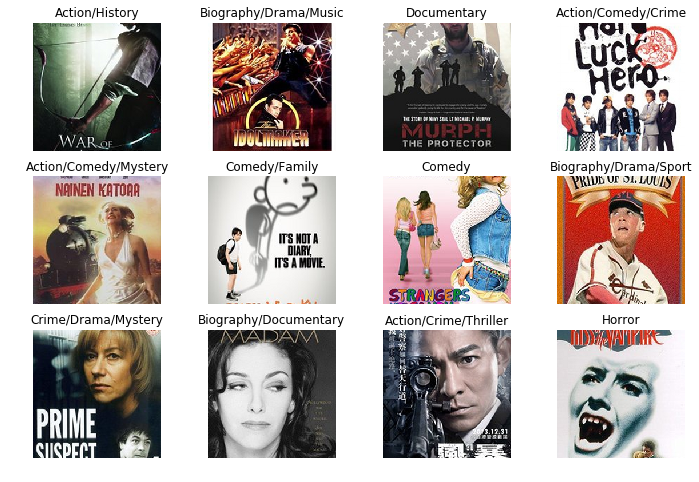

In [34]:
show_batch('valid.rec')

In [35]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)

In [36]:
pretrained_net.output

Dense(512 -> 1000, linear)

In [37]:
finetune_net = model_zoo.vision.resnet18_v2(classes=28)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())
# The model parameters in output will be updated using a learning rate ten
# times greater
finetune_net.output.collect_params().setattr('lr_mult', 10)

In [38]:
import time

In [49]:
def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    """Train and evaluate a model."""
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc,
                 time.time() - start))

In [54]:
def train_fine_tuning(net, learning_rate, batch_size=64, num_epochs=1):
    
    train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_iter = mx.gluon.data.DataLoader(validation_dataset, batch_size=batch_size)

    ctx = mx.cpu()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.SigmoidBinaryCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': 0.001})
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

In [44]:
x.shape

(64, 3, 224, 224)

In [41]:
X = mx.ndarray.random.uniform(shape=(634, 3, 224, 224))

In [45]:
y_hat = finetune_net(x); y_hat.shape

(64, 28)

In [47]:
y.shape

(64, 28)

In [68]:
X = finetune_net.features[1](X); X.shape

(634, 64, 112, 112)

In [ ]:
train_fine_tuning(finetune_net, 0.01)

training on cpu(0)
